In [1]:
import random
import math

In [2]:
class Customer:
    def __init__(self, cid, x, y, demand, pickup):
        self.id = cid; self.x = x; self.y = y
        self.demand = demand; self.pickup = pickup

In [3]:
class Depot:
    def __init__(self, did, x, y):
        self.id = did; self.x = x; self.y = y

In [4]:
class VRPSDP:
    def __init__(self, depots, customers, capacity, max_vehicles):
        self.depots = depots
        self.customers = customers
        self.capacity = capacity
        self.max_vehicles = max_vehicles
        # Precompute distances
        self.dist = {}
        nodes = [(f"D{d.id}", d.x, d.y) for d in depots] + [(c.id, c.x, c.y) for c in customers]
        for i,(id1,x1,y1) in enumerate(nodes):
            for j,(id2,x2,y2) in enumerate(nodes):
                self.dist[(id1,id2)] = math.hypot(x1-x2, y1-y2)
    def distance(self, id1, id2):
        return self.dist[(id1,id2)]
    def evaluate(self, solution):
        # solution: list of routes, each route=[cust_id,...], with parallel list vehicle_depot
        total_cost = 0
        penalty = 0
        for route, depot in zip(solution.routes, solution.vehicle_depots):
            prev = f"D{depot}"
            load_del = sum(self.customers[cid-1].demand for cid in route)
            load_pick = 0
            for cid in route:
                total_cost += self.distance(prev, cid)
                cust = self.customers[cid-1]
                load_del -= cust.demand
                load_pick += cust.pickup
                if load_del + load_pick > self.capacity:
                    penalty += (load_del + load_pick - self.capacity)
                prev = cid
            total_cost += self.distance(prev, f"D{depot}")
        solution.cost = total_cost + 1e6 * penalty
        return solution.cost
    def random_solution(self):
        # Randomly assign customers to up to max_vehicles routes (greedy fill)
        cust_ids = list(range(1, len(self.customers)+1))
        random.shuffle(cust_ids)
        routes = []
        vehicle_depots = []
        idx = 0
        for k in range(self.max_vehicles):
            if idx >= len(cust_ids):
                routes.append([]); vehicle_depots.append(self.depots[k % len(self.depots)].id)
                continue
            routes.append([]); vehicle_depots.append(self.depots[k % len(self.depots)].id)
            load_del = 0; load_pick = 0
            # Fill route until capacity or out of vehicles
            while idx < len(cust_ids):
                cid = cust_ids[idx]
                cust = self.customers[cid-1]
                if load_del + load_pick + cust.demand + cust.pickup <= self.capacity or k == self.max_vehicles-1:
                    routes[-1].append(cid)
                    load_del += cust.demand; load_pick += cust.pickup
                    idx += 1
                else:
                    break
        sol = Solution(routes, vehicle_depots)
        self.evaluate(sol)
        return sol

In [5]:
class Solution:
    def __init__(self, routes, vehicle_depots):
        self.routes = routes
        self.vehicle_depots = vehicle_depots
        self.cost = float('inf')

In [6]:
class ABC_Colony:
    def __init__(self, problem, pop_size=10, limit=20, max_iters=100):
        self.problem = problem
        self.pop_size = pop_size
        self.limit = limit
        self.max_iters = max_iters
    def initialize(self):
        self.population = [self.problem.random_solution() for _ in range(self.pop_size)]
        self.trials = [0]*self.pop_size
        self.best = min(self.population, key=lambda s: s.cost)
    def roulette_select(self, pop):
        fitness = [1.0/(s.cost+1e-9) for s in pop]
        total = sum(fitness)
        r = random.random()*total
        acc = 0
        for i,f in enumerate(fitness):
            acc += f
            if acc >= r:
                return i
        return len(pop)-1
    def order_crossover(self, parent1, parent2):
        seq1 = [cid for r in parent1.routes for cid in r]
        seq2 = [cid for r in parent2.routes for cid in r]
        n = len(seq1)
        if n < 2:
            return seq1[:]
        a, b = sorted(random.sample(range(n), 2))
        child = [None]*n
        child[a:b] = seq1[a:b]
        p2 = b
        for i in range(n):
            idx = (b + i) % n
            if child[idx] is None:
                # skip elements already in the copied segment
                while seq2[p2] in seq1[a:b]:
                    p2 = (p2 + 1) % n
                child[idx] = seq2[p2]
                p2 = (p2 + 1) % n
        return child
    def make_solution(self, seq):
        # Greedy split of sequence into routes for vehicles
        routes = []; vehicle_depots = []
        idx = 0
        for k in range(self.problem.max_vehicles):
            if idx >= len(seq):
                routes.append([]); vehicle_depots.append(self.problem.depots[k % len(self.problem.depots)].id)
                continue
            routes.append([]); vehicle_depots.append(self.problem.depots[k % len(self.problem.depots)].id)
            load_del = 0; load_pick = 0
            while idx < len(seq):
                cid = seq[idx]
                cust = self.problem.customers[cid-1]
                if load_del + load_pick + cust.demand + cust.pickup <= self.problem.capacity or k == self.problem.max_vehicles-1:
                    routes[-1].append(cid)
                    load_del += cust.demand; load_pick += cust.pickup
                    idx += 1
                else:
                    break
        sol = Solution(routes, vehicle_depots)
        self.problem.evaluate(sol)
        return sol
    def optimize(self):
        self.initialize()
        for _ in range(self.max_iters):
            # Employed bees
            for i in range(self.pop_size):
                j = i
                while j == i:
                    j = self.roulette_select(self.population)
                p1 = self.population[i]; p2 = self.population[j]
                child_seq = self.order_crossover(p1, p2)
                child = self.make_solution(child_seq)
                if child.cost < p1.cost:
                    self.population[i] = child; self.trials[i] = 0
                else:
                    self.trials[i] += 1
                if child.cost < self.best.cost:
                    self.best = child
            # Onlooker bees
            for _ in range(self.pop_size):
                i = self.roulette_select(self.population)
                j = i
                while j == i:
                    j = self.roulette_select(self.population)
                p1 = self.population[i]; p2 = self.population[j]
                child_seq = self.order_crossover(p1, p2)
                child = self.make_solution(child_seq)
                if child.cost < p1.cost:
                    self.population[i] = child; self.trials[i] = 0
                else:
                    self.trials[i] += 1
                if child.cost < self.best.cost:
                    self.best = child
            # Scout bees
            for i in range(self.pop_size):
                if self.trials[i] >= self.limit:
                    self.population[i] = self.problem.random_solution()
                    self.trials[i] = 0
        return self.best

In [7]:
# Example usage:
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 50_000_000  # 50 MB
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [8]:
# DATASET CREATION
depots = [Depot(1, 0, 0), Depot(2, 20, 0)]
customers = []
for i in range(1, 11):
    x = random.uniform(0, 20)
    y = random.uniform(0, 20)
    d = random.randint(1, 10)
    p = random.randint(1, 10)
    customers.append(Customer(i, x, y, d, p))

capacity = 30
max_vehicles = 3
problem = VRPSDP(depots, customers, capacity, max_vehicles)
abc = ABC_Colony(problem, pop_size=8, limit=15, max_iters=100)

>> Iteration completed, best cost so far: 177.07398962017385
>> Iteration completed, best cost so far: 177.07398962017385
>> Iteration completed, best cost so far: 177.07398962017385
>> Iteration completed, best cost so far: 148.7678833395791
>> Iteration completed, best cost so far: 148.7678833395791
>> Iteration completed, best cost so far: 146.23382585079852
>> Iteration completed, best cost so far: 146.23382585079852
>> Iteration completed, best cost so far: 130.9827887355854
>> Iteration completed, best cost so far: 130.9827887355854
>> Iteration completed, best cost so far: 130.9827887355854
>> Iteration completed, best cost so far: 130.9827887355854
>> Iteration completed, best cost so far: 130.9827887355854
>> Iteration completed, best cost so far: 109.26905853876198
>> Iteration completed, best cost so far: 109.26905853876198
>> Iteration completed, best cost so far: 109.26905853876198
>> Iteration completed, best cost so far: 109.26905853876198
>> Iteration completed, best co

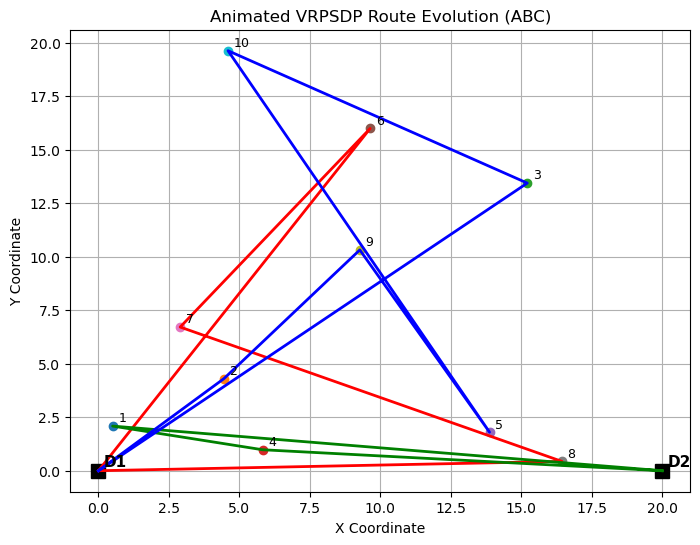

In [9]:
# ANIMATION SETUP
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
fig, ax = plt.subplots(figsize=(8, 6))

# Plot customers and depots
for cust in customers:
    ax.plot(cust.x, cust.y, 'o')
    ax.text(cust.x + 0.2, cust.y + 0.2, str(cust.id), fontsize=9)
for d in depots:
    ax.plot(d.x, d.y, 's', markersize=10, color='black')
    ax.text(d.x + 0.2, d.y + 0.2, f'D{d.id}', fontsize=11, fontweight='bold')

route_lines = []
for _ in range(problem.max_vehicles):
    line, = ax.plot([], [], '-', lw=2)
    route_lines.append(line)

ax.set_title('Animated VRPSDP Route Evolution (ABC)')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.grid(True)

# ABC WITH SNAPSHOTS
def abc_with_snapshots():
    history = []
    abc.initialize()
    for _ in range(abc.max_iters):
        for i in range(abc.pop_size):
            j = i
            while j == i:
                j = abc.roulette_select(abc.population)
            p1, p2 = abc.population[i], abc.population[j]
            child_seq = abc.order_crossover(p1, p2)
            child = abc.make_solution(child_seq)
            if child.cost < p1.cost:
                abc.population[i] = child
                abc.trials[i] = 0
            else:
                abc.trials[i] += 1
            if child.cost < abc.best.cost:
                abc.best = child
        for _ in range(abc.pop_size):
            i = abc.roulette_select(abc.population)
            j = i
            while j == i:
                j = abc.roulette_select(abc.population)
            p1, p2 = abc.population[i], abc.population[j]
            child_seq = abc.order_crossover(p1, p2)
            child = abc.make_solution(child_seq)
            if child.cost < p1.cost:
                abc.population[i] = child
                abc.trials[i] = 0
            else:
                abc.trials[i] += 1
            if child.cost < abc.best.cost:
                abc.best = child
        for i in range(abc.pop_size):
            if abc.trials[i] >= abc.limit:
                abc.population[i] = abc.problem.random_solution()
                abc.trials[i] = 0
        history.append(([[cid for cid in r] for r in abc.best.routes], list(abc.best.vehicle_depots)))
        print(f">> Iteration completed, best cost so far: {abc.best.cost}")

    print(">> ABC optimization completed.")
    return history

# Patch evaluation to discard capacity-violating solutions and log them
def patched_evaluate(self, solution):
    total_cost = 0
    for route, depot in zip(solution.routes, solution.vehicle_depots):
        prev = f"D{depot}"
        load_del = sum(self.customers[cid-1].demand for cid in route)
        load_pick = 0
        for cid in route:
            cust = self.customers[cid-1]
            load_del -= cust.demand
            load_pick += cust.pickup
            if load_del + load_pick > self.capacity:
                solution.cost = float('inf')
                return solution.cost
            total_cost += self.distance(prev, cid)
            prev = cid
        total_cost += self.distance(prev, f"D{depot}")
    solution.cost = total_cost
    return total_cost

VRPSDP.evaluate = patched_evaluate  # overwrite method

history = abc_with_snapshots()
print("Snapshots collected:", len(history))

# ANIMATION FUNCTION
def update(frame):
    routes, vdepots = history[frame]
    for i, (route, depot_id) in enumerate(zip(routes, vdepots)):
        if not route:
            route_lines[i].set_data([], [])
            continue
        depot = [d for d in depots if d.id == depot_id][0]
        x, y = [depot.x], [depot.y]
        for cid in route:
            c = customers[cid - 1]
            x.append(c.x)
            y.append(c.y)
        x.append(depot.x)
        y.append(depot.y)
        route_lines[i].set_data(x, y)
        route_lines[i].set_color(colors[i % len(colors)])
    return route_lines

ani = FuncAnimation(fig, update, frames=len(history), interval=300, blit=True, repeat=False)
#plt.show()

In [10]:
%matplotlib notebook
from IPython.display import HTML
HTML(ani.to_jshtml())

In [ ]:
best_solution = abc.optimize()
print("Best distance:", best_solution.cost, "Routes:", best_solution.routes)